# Imports

In [17]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt
import os
import wave
import contextlib
plt.rcParams['figure.figsize'] = 50, 20


# Read the denoised resampled wav file

In [6]:
wave_file = os.path.join(os.getcwd(), "denoise2.wav")
sample_rate, data_denoised = wf.read(wave_file)
print("Data shape {} , sampling rate is {}".format(data_denoised.shape, sample_rate))

Data shape (2434192,) , sampling rate is 16000


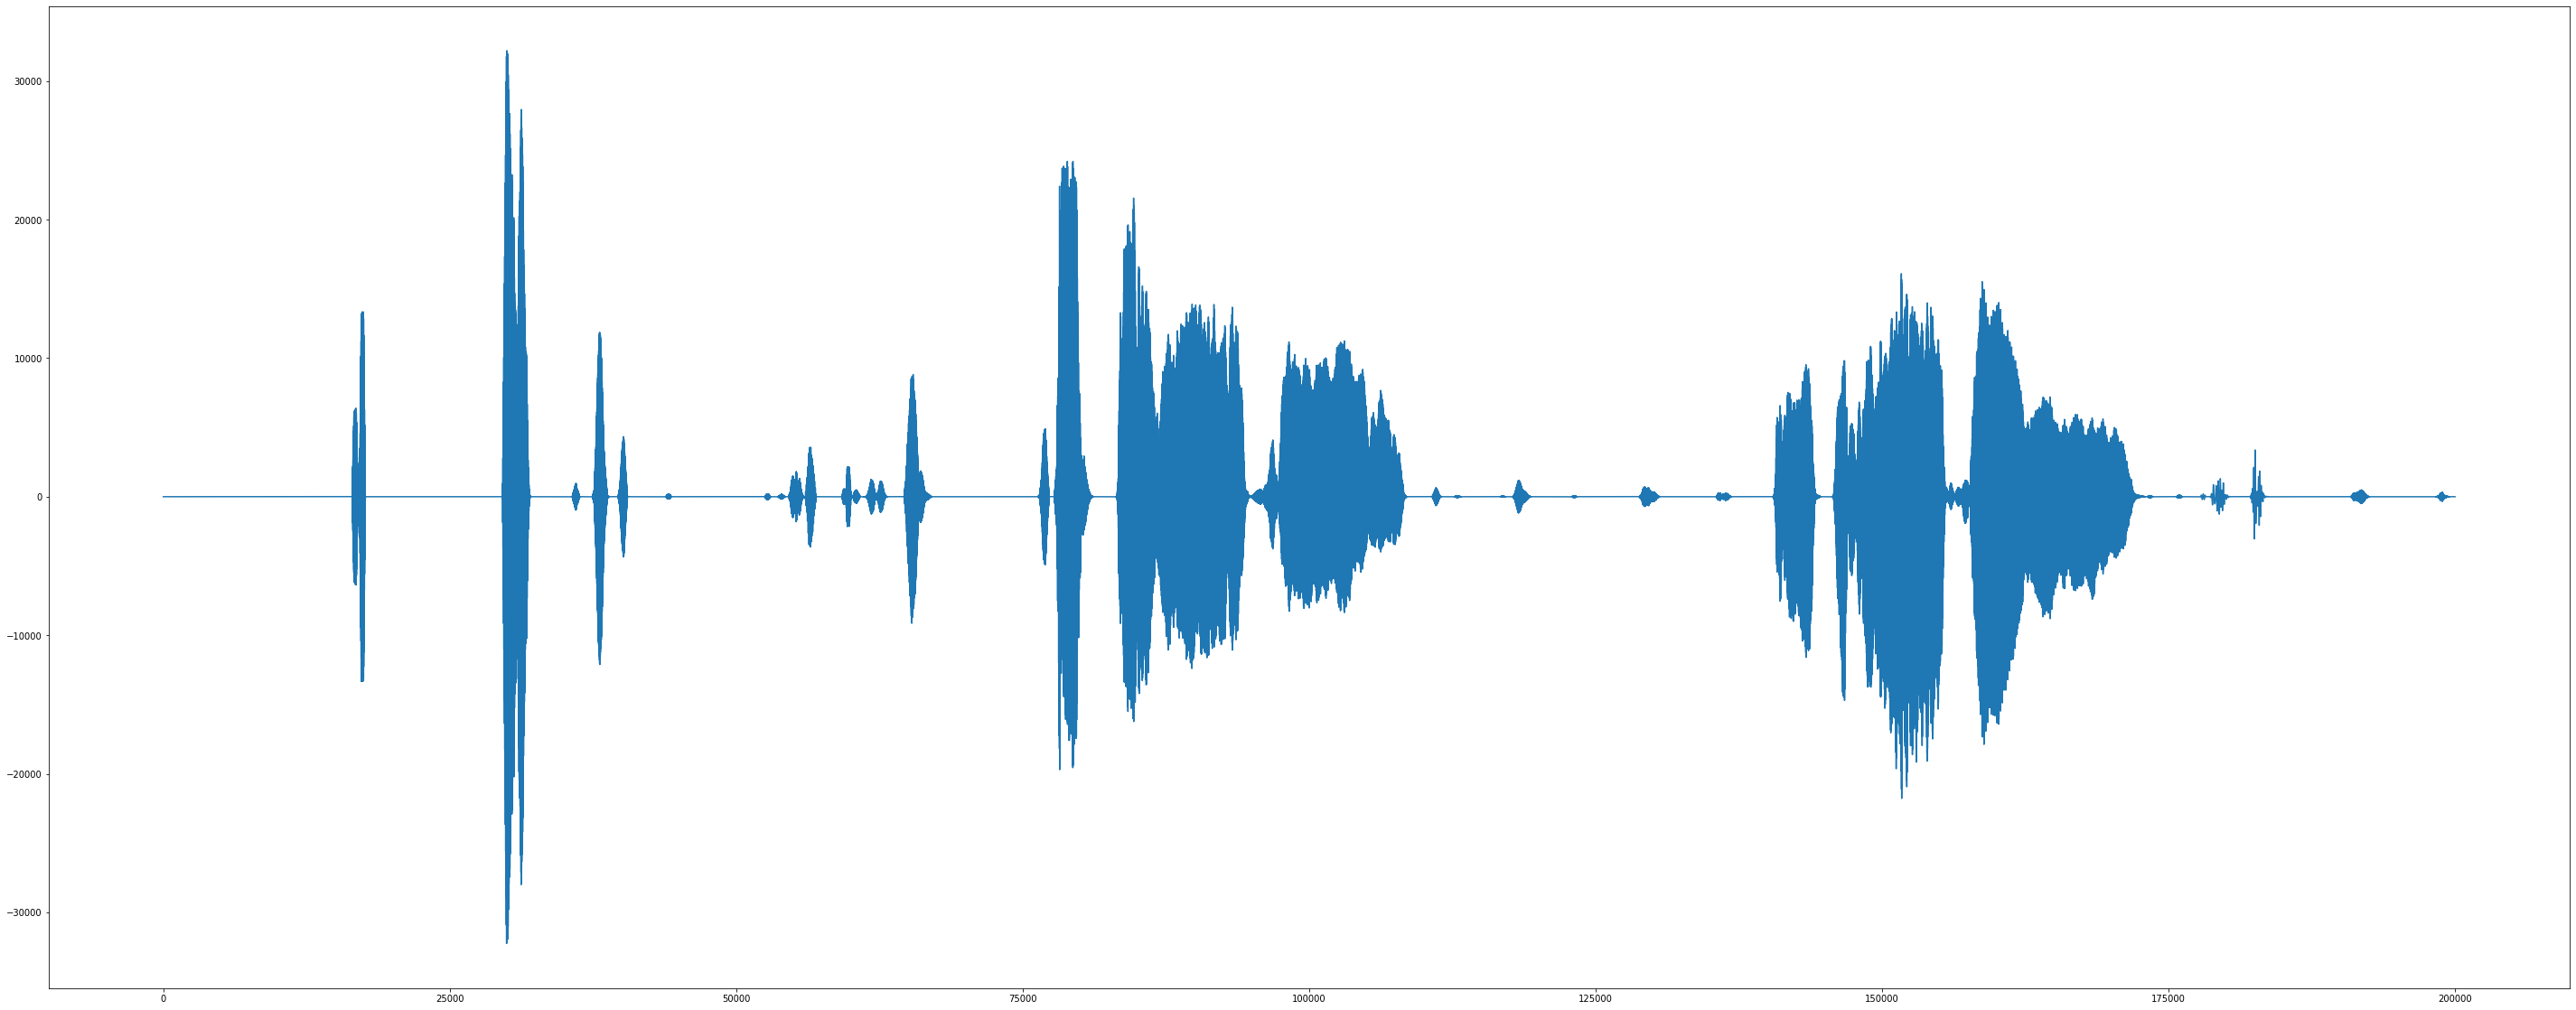

In [7]:
# Plot part of the signal
plt.plot(data_denoised[:200000])


# Calculate the signal autocorrelation (power)

In [19]:
# Window size of 20 ms with an overlap of 10ms
window_size = 0.02 # 20 ms 
window_overlap = 0.015 # 10ms overlap
samples_per_window = int(window_size * sample_rate)
n_windows = int(np.ceil(len(data_denoised) / samples_per_window))
n_sample_shift = int((window_overlap / window_size) * samples_per_window)
print("n samples per window: {}, n_windows: {}".format(samples_per_window, n_windows))

n samples per window: 320, n_windows: 7607


In [20]:
# Loop through the segments using the window and overlapped version and compute the autocorrelation
AC = list()
for i in range(n_windows): 
    start = i * samples_per_window 
    end = (i+1) * samples_per_window
    if end > len(data_denoised): 
#         print(start, end)
        continue
    first_win = data_denoised[ start : end ]
    second_win = data_denoised[start + n_sample_shift : end + n_sample_shift]
    sig_power = np.abs(first_win * second_win).sum() / window_size
    AC.append(sig_power)
    

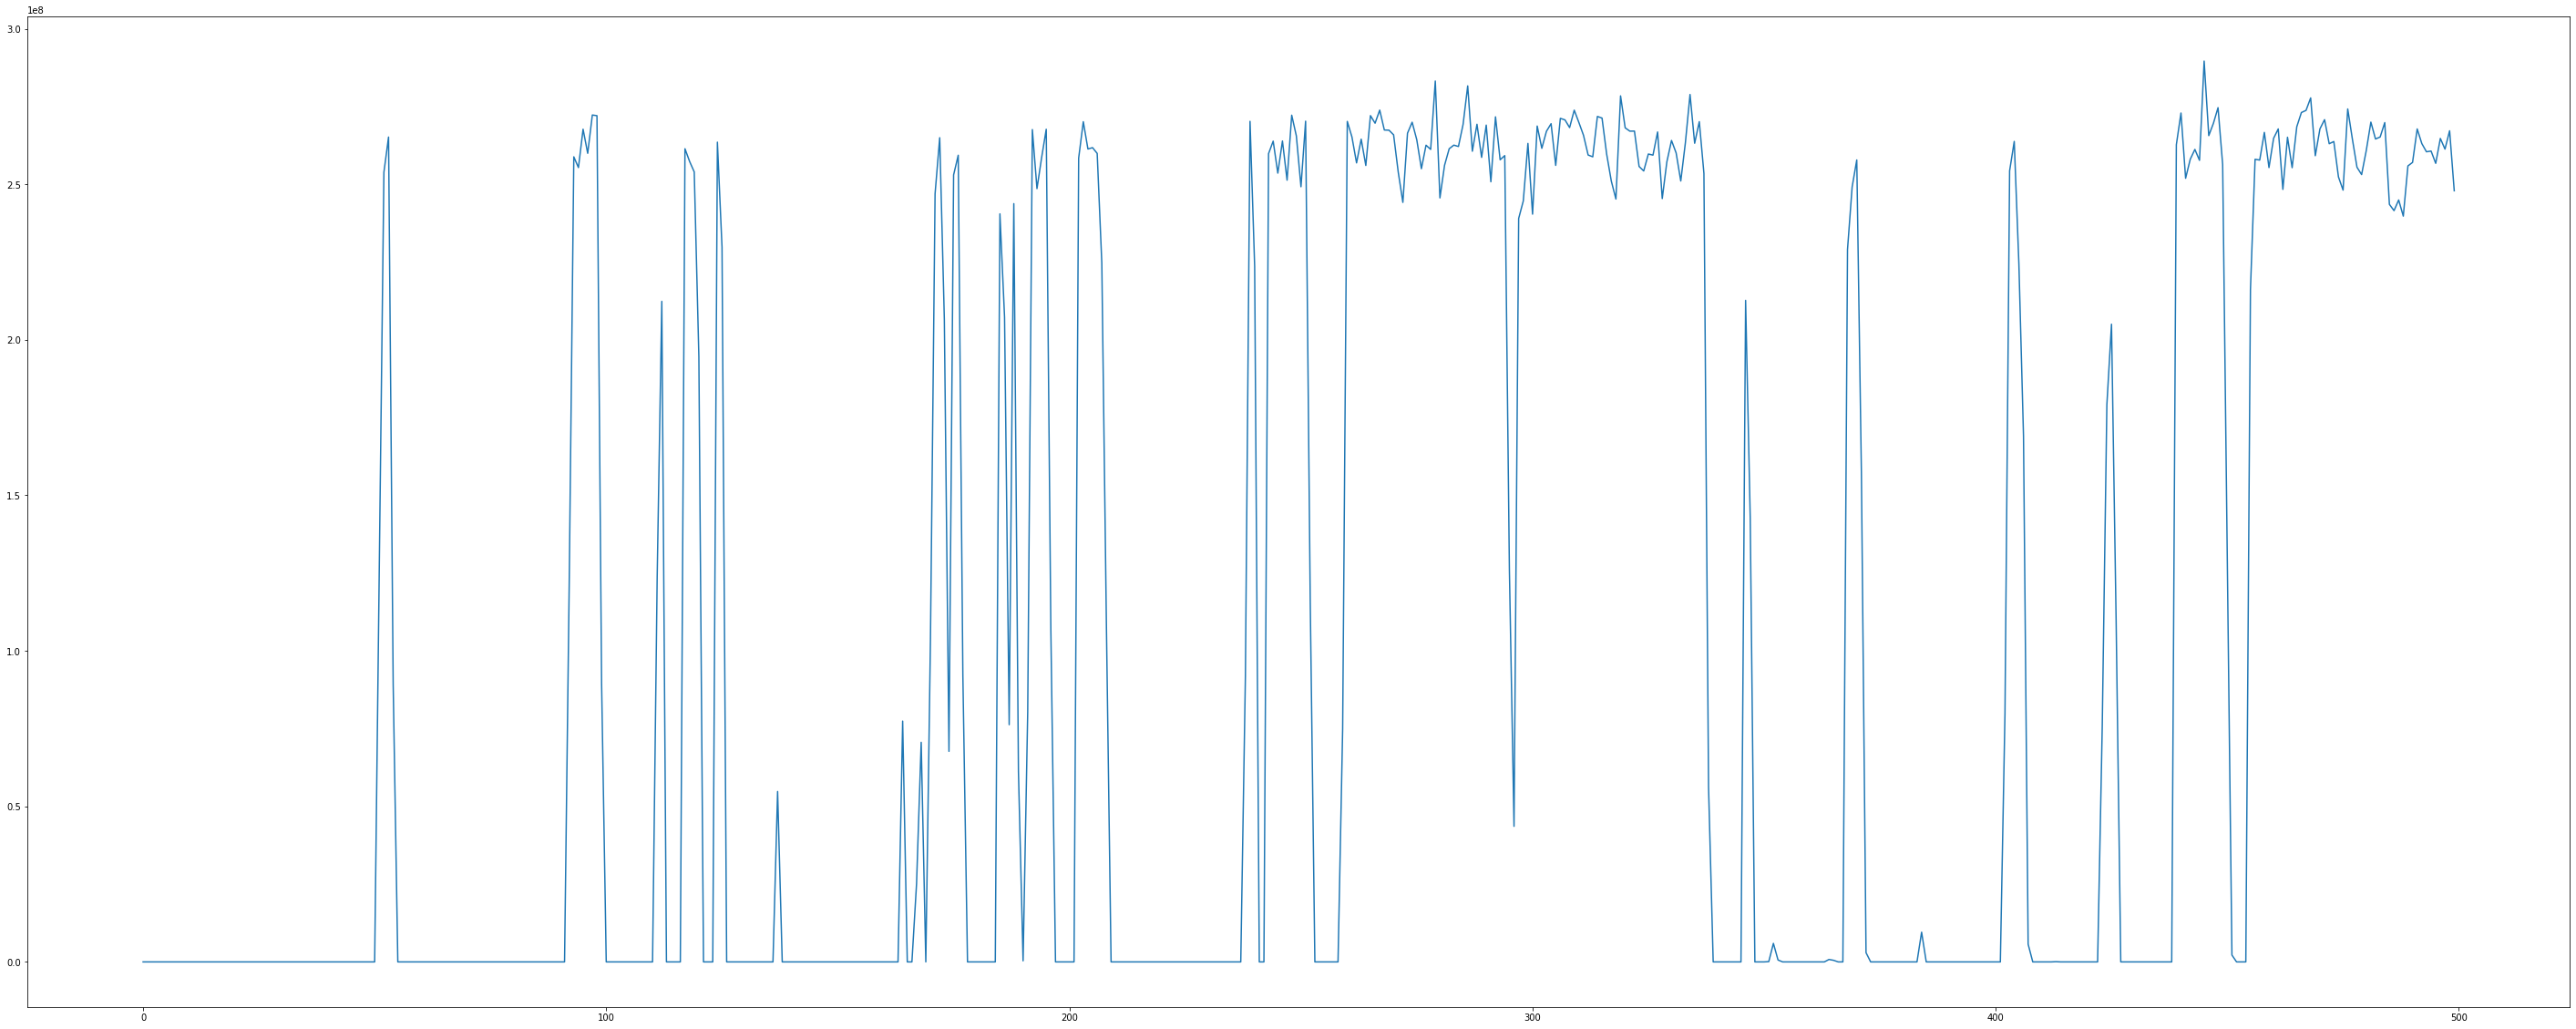

In [14]:
plt.plot(AC[:500])

# Apply a median filter to flatten out the spikes in the signal

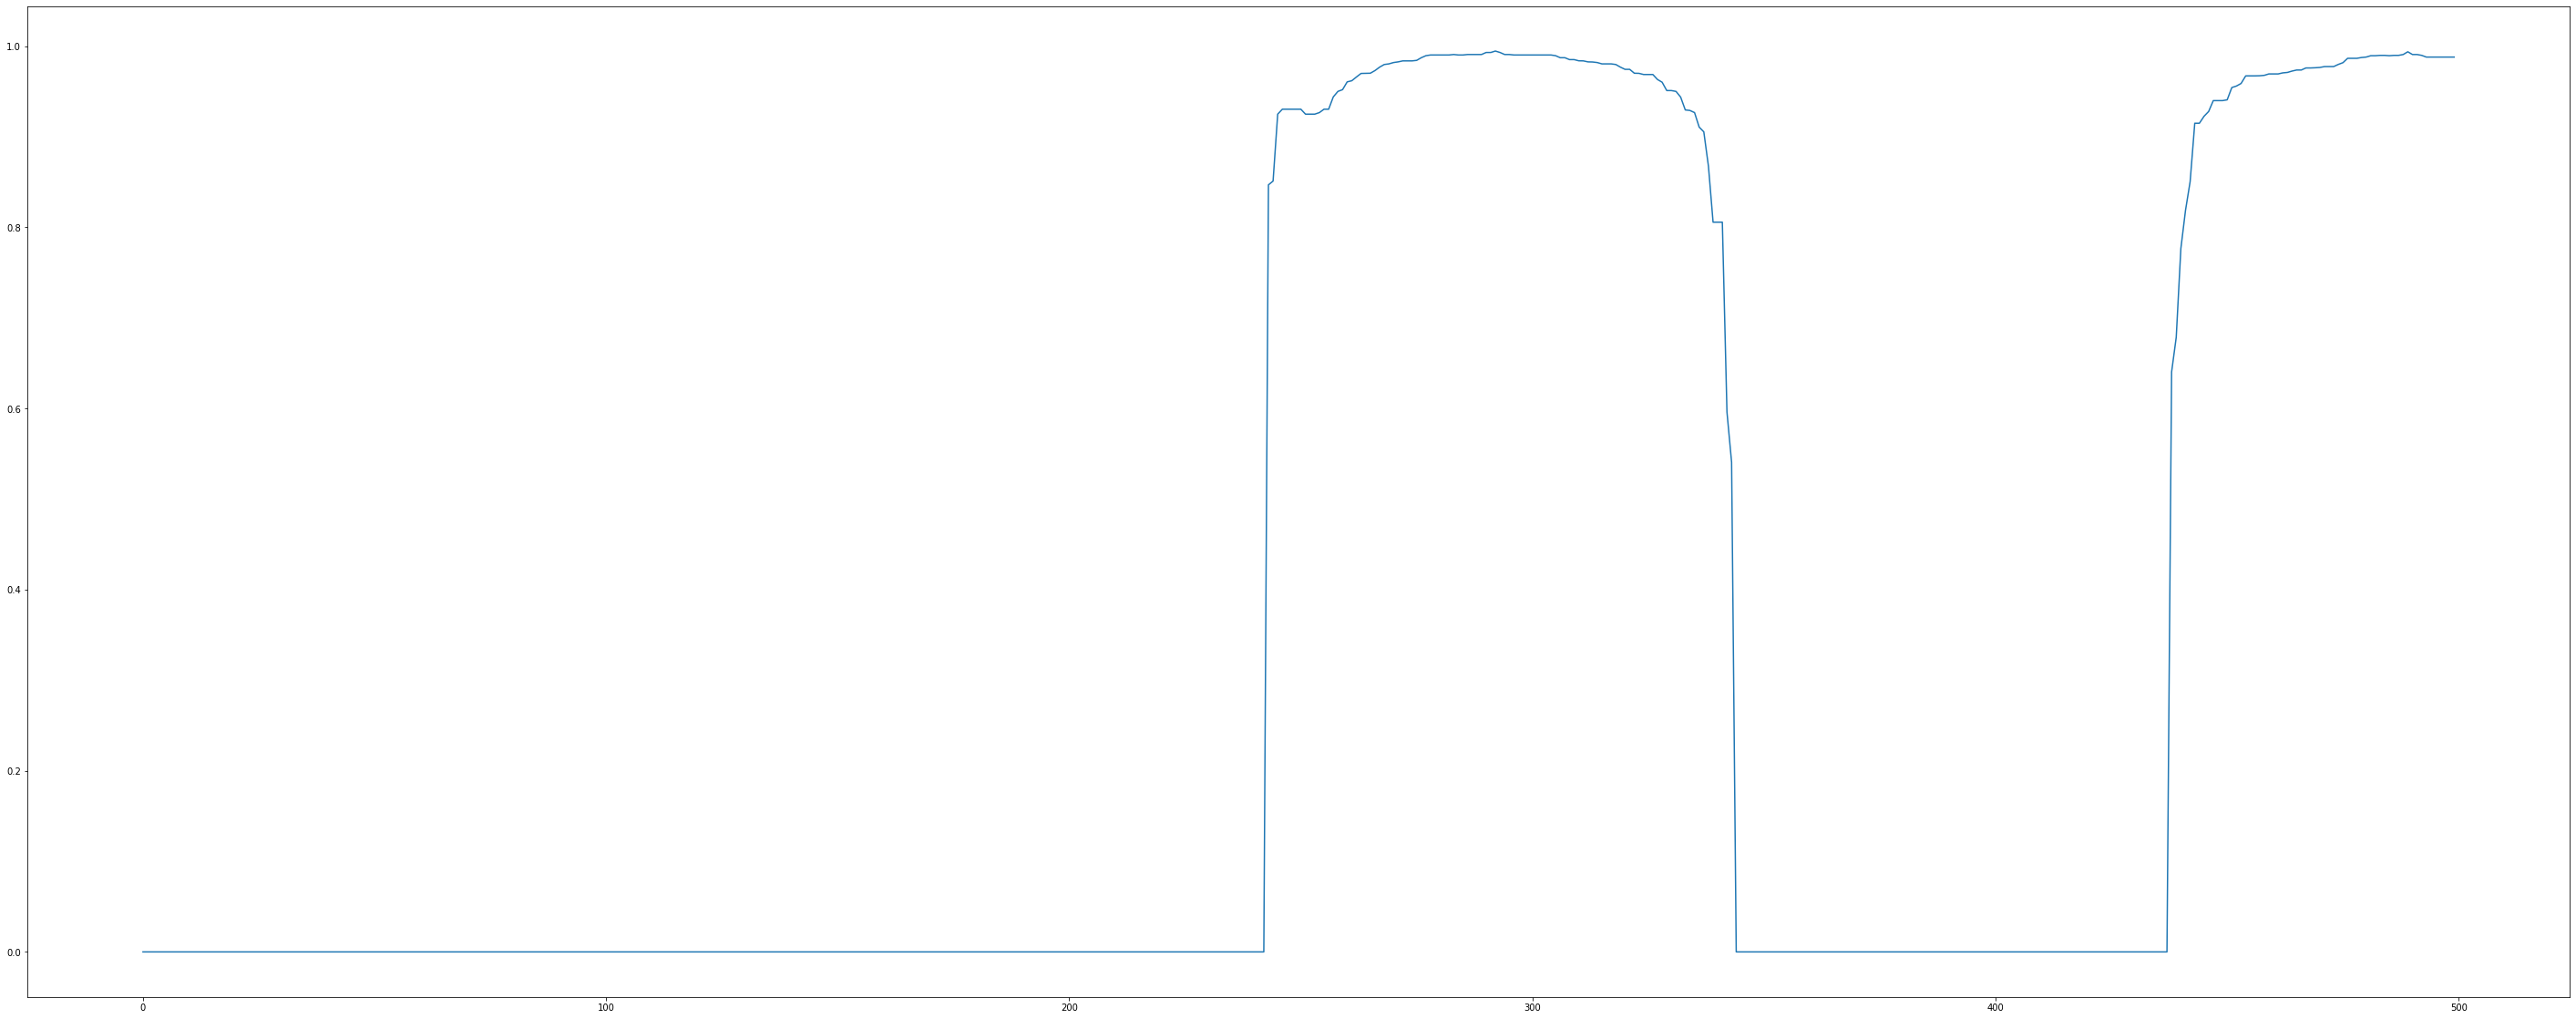

In [21]:
AC = np.asarray(AC)
AC = sps.medfilt(AC,89)  # 1sec = 50 window , 89 is kinda good
# normalise AC between 0 and 1
AC = (AC - np.min(AC)) / (np.max(AC) - np.min(AC))
# Threshold the autocorrelation to avoid false (smoothed out) unvoiced signals, i.e. to detect drops in signal
AC[AC < 0.5] = 0
plt.plot(AC[:500])

# Voice acitivity detection

In [22]:
# Loop window by window, check accumlated power, and mask the signal
mask = list()
threshold = 0.1
ac_win_size = 1
buffer = [AC[0]]  # power in the first window
for i in range(1, len(AC)-1):  
    current_power = AC[i].mean()
    avg_buffer_power = np.asarray(buffer).mean()
    power_ratio = current_power / (avg_buffer_power + 1e-6)
    # transition from 0 to 1
    if power_ratio > threshold and mask[-1] == 0:   
        mask.append(1)
        buffer = [current_power]
        
    # accumalation of power in the voiced intervals
    elif power_ratio > threshold and mask[-1] == 1:   
        mask.append(1)
        buffer.append(current_power)
    # accumlation of power in unvoiced intervals
    else:   
        mask.append(0)
        buffer.append(current_power)

mask= np.asarray(mask)

# Create per sample mask

In [23]:
per_sample_mask = np.zeros(len(data_denoised))
for i in range (len(mask)): 
    per_sample_mask[i * samples_per_window: (i+1) * samples_per_window] = mask[i] 

# Calculating the final output

In [118]:
number_of_roosters = len(np.argwhere(np.diff(per_sample_mask)).squeeze()) // 2
transitions = np.argwhere(np.diff(per_sample_mask)).squeeze() 
trans_in_msecs = transitions /  16
# computing the segments
segments = {i//2: (trans_in_msecs[i+1] - trans_in_msecs[i], trans_in_msecs[i], trans_in_msecs[i+1]) for i in range(0, len(trans_in_msecs),2)}
# sorted_segments = sorted(segments.items(), key=lambda x: x[1][0], reverse=True)
# sorted_segments
segments_df = pd.DataFrame.from_records(segments).T.set_index(np.arange(1,len(segments)+1))
segments_df.columns = ["Crow_time (ms)", "Start (ms)", "End (ms)"]
segments_df = segments_df.sort_values(by="Crow_time (ms)", ascending=False)
segments_df.style.highlight_max(subset = ["Crow_time (ms)"], color = 'lightgreen', axis = 0)



,Crow_time (ms),Start (ms),End (ms)
15,2560,68039.9,70599.9
8,2560,33719.9,36279.9
5,2540,20199.9,22739.9
23,2500,108820,111320
12,2440,53539.9,55979.9
30,2360,148880,151240
18,2160,85959.9,88119.9
2,2120,8739.94,10859.9
10,2080,44579.9,46659.9
16,2080,72579.9,74659.9


**We have 30 roosters in the signal**  &
**It seems that rooster 8 and rooster 15 are the winners** 